First, let us load some libraries.

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from torch import nn, optim
from scipy.optimize import curve_fit
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from collision_wrapper import collOT_c as newot
from collision_wrapper import ISA_c as ISA
from utility import *
import time
import tracemalloc
from scipy.stats import linregress
from scipy.optimize import curve_fit

# load POT
! pip3 install POT
import ot

# load pytorch
from torch import nn, optim
import torch

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers=["o", "s", "d", "<", "^"]
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]

Define some useful functions:

In [24]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

def find_sinkhorn_map_nd(X0, Y0, lambd = 1e-3, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.sinkhorn(a, b, M, reg=lambd, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

# Learning five-marginal map

We generate samples of each marginals. This includes Swiss-Roll, Banana, Funnel, and Ring distributions.

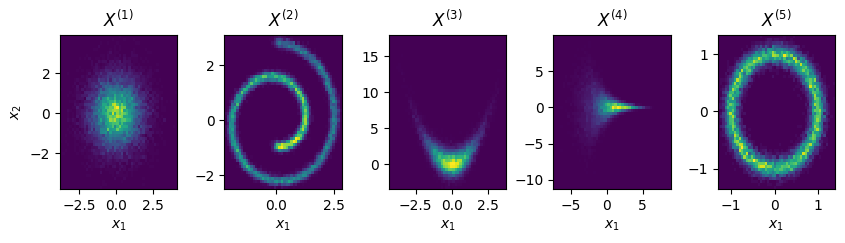

In [41]:
def generate_5marginals(Np, seed=0):
    dim=2; 
    Nm=5;
    #normal
    nr = np.random.normal(0,1,(Np,dim))

    #swiss roll
    sr = swissroll(Np)

    #banana
    bn = sample_banana(Np)

    #funnel
    funnel = Funnel(d=2,sigma=2)
    fn = funnel.sample(Np)

    #ring
    ring = Ring(d=2,sigma=0.1, radia=1.0)
    rg = ring.sample(Np)

    X = np.zeros((Nm,Np,dim))
    X[0,:,:] = nr;
    X[1,:,:] = sr;
    X[2,:,:] = bn;
    X[3,:,:] = fn;
    X[4,:,:] = rg;
    return X, Nm, dim

Np = 2*10**4 # number of points/particles/samples
X, Nm, dim = generate_5marginals(Np)

X00 = X.copy()

fig, axes = plt.subplots(1, Nm, figsize=(2*Nm, 2))

for i in range(Nm):
    axes[i].hist2d(X[i,:,0], X[i,:,1], bins=50)
    axes[i].set_title(r"$X^{("+str(i+1)+")}$")
    axes[i].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")
fig.subplots_adjust(wspace=0.4, hspace=0.0)

## Solving MMOT using collision-based OT
Here, we use the c-implementation of the collision-based dynamics to solve the 5-marginal OT problem to find the optimal pairing between samples of all marginals.

In [42]:
X = X00.copy()
X, dists_coll_xy, nt = newot(X, MinIter=5000, MaxIter=10000, tol = 1e-9, avg_window=20, Track=1)

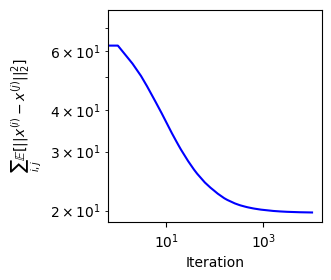

In [43]:
fig, ax = plt.subplots();
ax.plot(np.array(dists_coll_xy), color="blue")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\sum_{i,j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_cost_5marginal.pdf',format='pdf', bbox_inches="tight", dpi=300)

Next, we devise a Neural Network to learng the map from normal to four other marginals, i.e. Swiss-roll, Funnel, Banana, and Rung.

In [44]:
class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, out_marg=4):
        super(Model, self).__init__()
        self.out_marg = out_marg
        self.input_dim = input_dim
        
        self.fc0 = nn.Sequential(
            nn.Linear(input_dim, input_dim*out_marg)
        )
            
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim*out_marg)
        )

    def forward(self, x):
        # x:  (Np, dim)
        x = self.fc(x) # (Np, input_dim*out_marg)

        x = x.view(x.shape[0], self.out_marg, self.input_dim)
        
        x = x.permute(1, 0, 2)
        
        # output x: out_marg, Np, input_dim
        return x
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=2))
        return loss

Epoch 1000, Loss: 0.023149777203798294
Epoch 2000, Loss: 0.016600487753748894
Epoch 3000, Loss: 0.01491268165409565
Epoch 4000, Loss: 0.014125417917966843
Epoch 5000, Loss: 0.013448579236865044
Epoch 6000, Loss: 0.012736862525343895
Epoch 7000, Loss: 0.012174928560853004
Epoch 8000, Loss: 0.011557252146303654
Epoch 9000, Loss: 0.010857765562832355
Epoch 10000, Loss: 0.010427752509713173


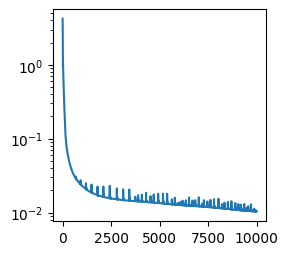

In [45]:
Xtr = torch.tensor(X[0,:,:], dtype=torch.float32)
Ytr = torch.tensor(X[1:,:,:], dtype=torch.float32)

# Create a simple model and optimizer
model_coll = Model(input_dim=2)
optimizer = optim.Adam(model_coll.parameters(), lr=1e-3)

# Training loop
n_epochs = 10000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_coll.loss(Xtr, Ytr)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model_coll.eval()

fig, ax = plt.subplots();
ax.plot(losses)
ax.set_yscale("log")
fig.set_size_inches(size*cm, size*cm)

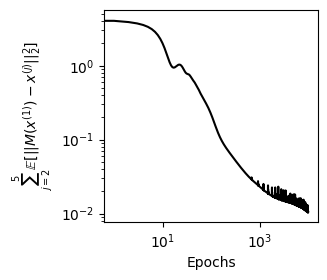

In [46]:
fig, ax = plt.subplots();
ax.plot(losses, color="black")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Epochs')
ax.set_ylabel(r'$\sum_{j=2}^5 \mathbb{E}[||M(x^{(1)})-x^{(j)}||_2^2]$')

fig.set_size_inches(size*cm, size*cm)
fig.savefig('train_map_1-to-4marginal.pdf',format='pdf', bbox_inches="tight", dpi=300)

Now that we have trained NN on optimally paired samples, we draw new samples for testing.

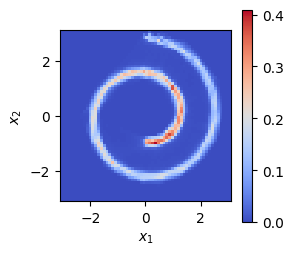

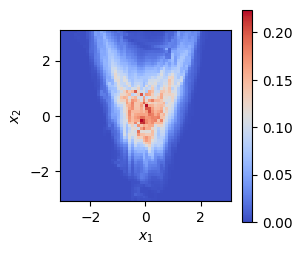

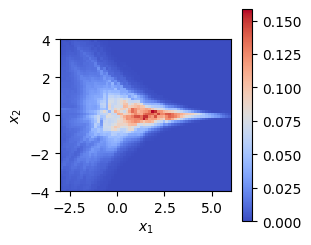

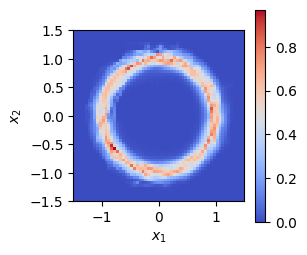

In [47]:
def plot_2d_density_single(x, xp=None, bins=60, range=[[-1.5,1.5],[-1.5,1.5]]):
    if xp is None:
        xp = x
    fig = plt.figure()
    # Create the second subplot of Y
    ax = plt.subplot()
    hist = plt.hist2d(x[:,0 ], x[:, 1], bins=bins, density=True, cmap='coolwarm', range=range)
    plt.colorbar()
    ax.set_aspect('equal', adjustable='box')  # Ensure aspect ratio is 1
    return fig, ax


Xtest = np.random.normal(0,1,(5*10**6,2))
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = model_coll.forward(Xtest)

Ytest_np = Ytest.detach().numpy()

# first output marginal
iNm = 0
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3.1,3.1],[-3.1,3.1]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('swiss_roll_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

# second marginal
iNm = 1
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3.1,3.1],[-3.1,3.1]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('banana_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)


# third marginal
iNm = 2
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3,6],[-4,4]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('funnel_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

# fourth marginal
iNm = 3
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-1.5,1.5],[-1.5,1.5]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('ring_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

plt.show()

## Convergence w.r.t $N_p$
We carry out a convergence study in solving the MMOT problem using the collision-based and ISA methods for a range of number of sampes per marginal $N_p$.

In [26]:
tracemalloc.start()

Nps = [1000, 2000, 4000, 8000, 16000]

navg = 1
times = [0 for i in range(len(Nps))]
mems = [0 for i in range(len(Nps))]
w2s = [[[] for k in range(navg)] for i in range(len(Nps))]

times_isa = [0 for i in range(len(Nps))]
mems_isa = [0 for i in range(len(Nps))]
w2s_isa = [[[] for k in range(navg)] for i in range(len(Nps))]
for j in range(len(Nps)):
    Np = Nps[j]
    m = 0
    t = 0
    m_isa = 0
    t_isa = 0
    for k in range(navg):
        tracemalloc.reset_peak()
        first_size, first_peak = tracemalloc.get_traced_memory()
        
        X0, Nm, dim = generate_5marginals(Np, seed=k)
        
        X = X0.copy()
        start_time = time.time()
        X, dists_coll_xy, nt = newot(X, MinIter=3000, MaxIter=3000, tol = 1e-9, avg_window=20, Track=1)
        t += time.time() - start_time
        first_size, second_peak = tracemalloc.get_traced_memory()
        m += second_peak - first_peak
        w2s[j][k] = dists_coll_xy
        del X, dists_coll_xy

        X = X0.copy()
        start_time = time.time()
        X, dists_coll_xy, nt = ISA(X, MinIter=6, MaxIter=6, tol = 1e-3, avg_window=1, Track=1)
        t_isa += time.time() - start_time
        first_size, second_peak = tracemalloc.get_traced_memory()
        m_isa += second_peak - first_peak
        w2s_isa[j][k] = dists_coll_xy
        del X, dists_coll_xy

    mems[j] = m/(1.*navg)
    times[j] = t/(1.*navg)
    mems_isa[j] = m_isa/(1.*navg)
    times_isa[j] = t_isa/(1.*navg)
    print(r"Np:", Np, flush=True)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


/tmp/ipykernel_26107/1504640307.py:58: RuntimeWarning: overflow encountered in exp
  return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
/tmp/ipykernel_26107/1504640307.py:58: RuntimeWarning: overflow encountered in multiply
  return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
/tmp/ipykernel_26107/1504640307.py:62: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)


53.9289307463359 -0.3387043081932369 0.0


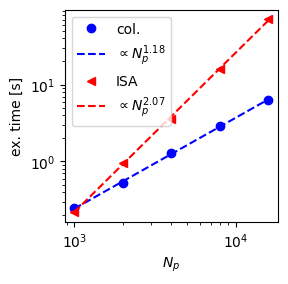

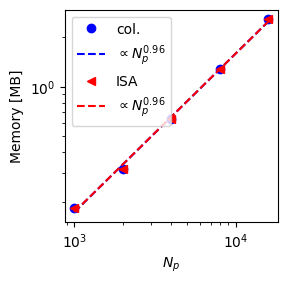

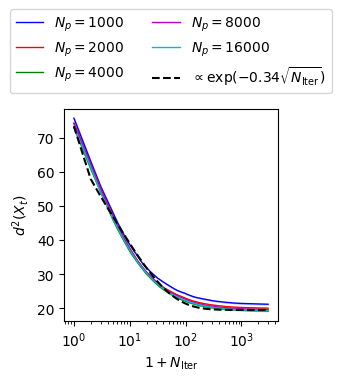

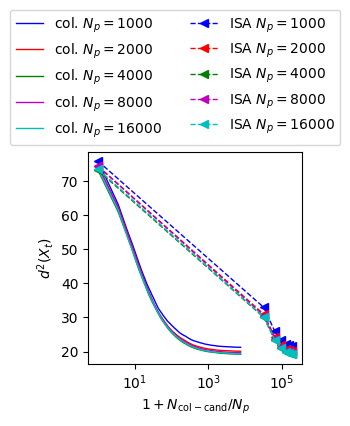

In [29]:
fig, ax = plt.subplots();

ax.plot(Nps, times, marker="o", color="blue", linewidth=0, label="col.")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, times)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, times_isa, marker="<", color="red", linewidth=0, label="ISA")
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, times_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals__time_vs_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();

mems = np.array(mems)
mems_isa = np.array(mems_isa)
ax.plot(Nps, mems/1e6, marker="o", color="blue", linewidth=0, label="col.")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, mems/1e6)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, mems_isa/1e6, marker="<", color="red", linewidth=0, label="ISA")
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, mems_isa/1e6)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals__memory_vs_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
w2s = np.array(w2s)
for j in range(len(Nps)):
    mean = np.mean(w2s[j,:,:], axis=0) 
    std = np.std(w2s[j,:,:], axis=0)
    x = np.array([i+1 for i in range(len(mean))])
    ax.plot(x, mean, color=cls[j], linewidth=1, label=r"$N_p=$"+str(Nps[j]) ) #, marker=markers[j], markevery=50+10*j, markersize=4)
    plt.fill_between(x, mean-std, mean+std, color=cls[j], alpha=0.2)

def exponential_function(x, a, b, c):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1, 0]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted, c_fitted = params
print(a_fitted, b_fitted, c_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted, c_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"\sqrt{N_\mathrm{Iter}})$", linestyle="--")

plt.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'${\sum_{i\neq j} \mathbb{E}[||x_t^{(i)}-x_t^{(j)}||_2^2]}/{\sum_{i\neq j} \mathbb{E}[||x_0^{(i)}-x_0^{(j)}||_2^2]}$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals_W2evol.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
for j in range(len(Nps)):
    mean = np.mean(w2s[j,:,:], axis=0)
    std = np.std(w2s[j,:,:], axis=0)
    mean = mean #/ mean[0]
    xx = np.array([i for i in range(w2s.shape[2])])
    xx = xx*Nm/2.+1
    ax.plot(xx, mean, color=cls[j], linewidth=1, label=r"col. $N_p=$"+str(Nps[j])) #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)
    
for j in range(len(Nps)):
    err = np.array(w2s_isa[j])
    mean = np.mean(err, axis=0)
    std = np.std(err, axis=0)
    mean = mean #/ mean[0]
    xx = np.array([i for i in range(len(mean))])
    xx = xx*(Nm-1)*(Np-1)/2.+1
    ax.plot(xx, mean, color=cls[j], label=r"ISA $N_p=$"+str(Nps[j]), marker="<", linewidth=1, linestyle="--") #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 1.35),ncol=2)
ax.set_xlabel(r'$1+N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals_W2evol_Ncol.pdf',format='pdf', bbox_inches="tight", dpi=300);

## Compare each normal to target against EMD and Sinkhorn solutions

### Normal and Swiss Roll

In [111]:
tracemalloc.start()

navg = 10
dim = 2
Nps = [1000, 2000, 4000, 8000, 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
iter_isa_xy = []
hist_isa_w = [[] for i in range(len(Nps))]
err_hist_isa_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      #swiss roll
      y00 = swissroll(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      #print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      #print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

      ## compute ISA
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_isa_xy, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
      hist_isa_w[k-1].append(np.array( (dists_isa_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_isa_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


5.140226507347091 -0.4013332137416909


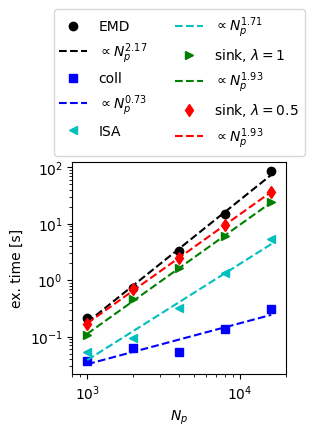

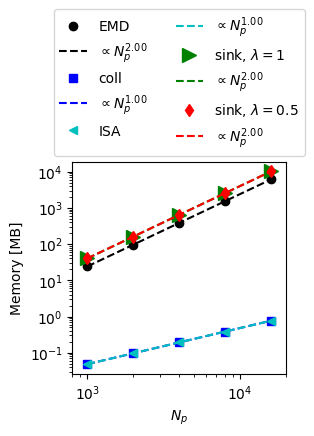

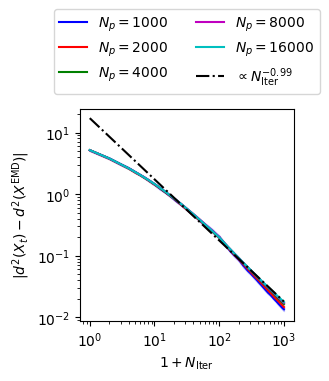

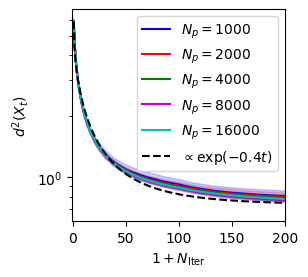

In [112]:
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$|d^2(X_t)-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t)$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


### Normal and Banana

In [13]:
tracemalloc.start()

rng = np.random.seed(1)

navg = 4
dim = 2
Nps = [1000, 2000, 4000, 8000, 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
iter_isa_xy = []
hist_isa_w = [[] for i in range(len(Nps))]
err_hist_isa_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      #banana
      y00 = sample_banana(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      #print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      #print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

      ## compute ISA
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_isa_xy, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
      hist_isa_w[k-1].append(np.array( (dists_isa_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_isa_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


4.964490081968092 -0.3551505062254672


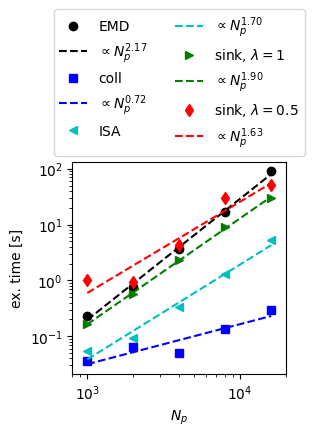

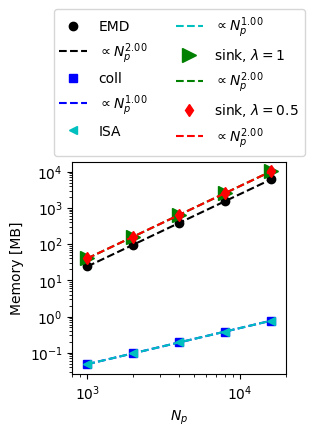

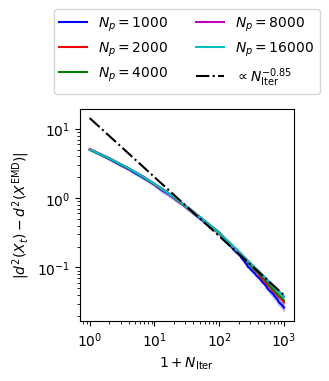

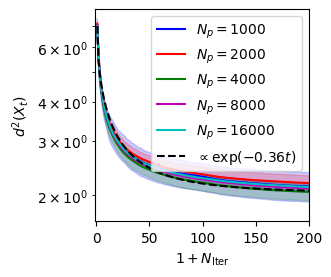

In [14]:
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$|d^2(X_t)-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t)$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


### Normal and Funnel

In [15]:
tracemalloc.start()

rng = np.random.seed(1)

navg = 4
dim = 2
Nps = [1000, 2000, 4000, 8000, 16000]

funnel = Funnel(d=2,sigma=2)

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
iter_isa_xy = []
hist_isa_w = [[] for i in range(len(Nps))]
err_hist_isa_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      y00 = funnel.sample(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      #print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      #print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

      ## compute ISA
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_isa_xy, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
      hist_isa_w[k-1].append(np.array( (dists_isa_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_isa_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


6.70378777008413 -0.35542402282226865


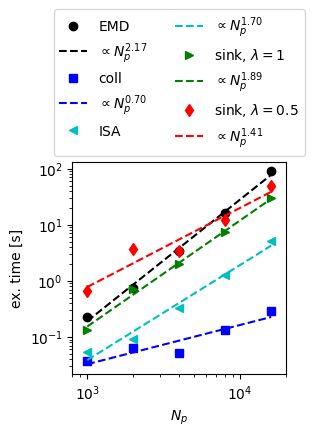

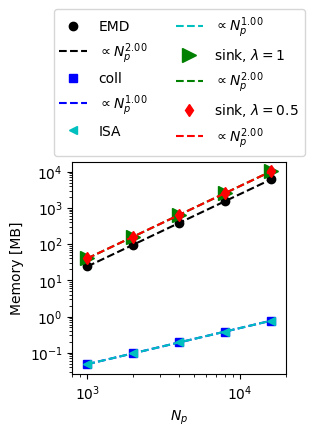

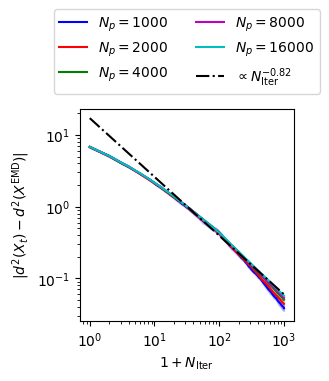

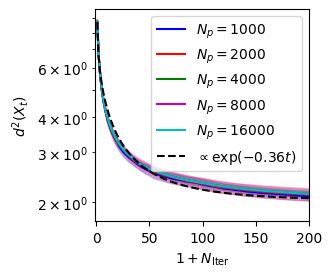

In [16]:
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$|d^2(X_t)-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t)$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


### Normal and Ring

In [17]:
tracemalloc.start()

rng = np.random.seed(1)

navg = 2
dim = 2
Nps = [1000, 2000, 4000, 8000, 16000]

ring = Ring(d=2,sigma=0.1, radia=1.0)

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
iter_isa_xy = []
hist_isa_w = [[] for i in range(len(Nps))]
err_hist_isa_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      y00 = ring.sample(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      #print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      #print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

      ## compute ISA
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_isa_xy, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
      hist_isa_w[k-1].append(np.array( (dists_isa_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_isa_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


2.602168380338762 -0.4203365150956419


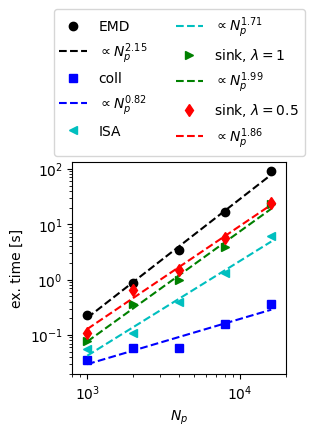

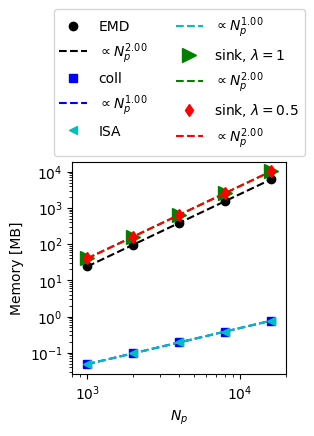

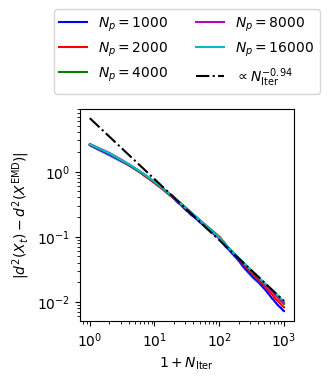

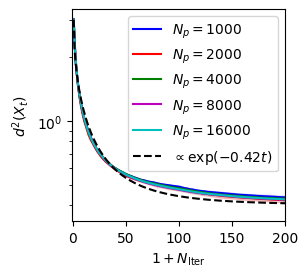

In [18]:
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$|d^2(X_t)-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t)$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);
